__We will use the following methods to prepare the model__

1. Data size used: 2 million out of 55 million
2. Dropped all rows with missing values (14 rows)
3. We have used those records with fare between \\$2.5 and \\$100
4. Passenger count variable: we have considered values 1-5 only 
5. Location Data: Rows with outliers are removed

6. Feature Engineering: 
    New Features: Distance (haversine), year, month, day of the month, week, hour, lat_diff, lon_diff

7. Deleted records when distance=0 to increase model accuracy

8. One-hot encoding for categorical columns: year, month, day of the month, week, hour, passenger_count

9. Machine Learning Model:
    i.  lat_diff, lon_diff produces a better result than data sets with distance variable.
    
    ii. Parameter tuning for light gbm model using GridSearchCV:
                        'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 31
    
    iii. Model accuracy with Multicollinearity:
            a. Multicollinearity Analysis with lat_lon_diff: 
                Features Removed: wk_Friday, dt_Afternoon, mn_April, dd_1, yr_2009, pc_1
            
            b. Accuracy:
                lgbm: Validation:          rmse = 3.67 	 mape = 18.87
                lgbm v2: Validation:       rmse = 3.65 	 mape = 18.67
                random_forest: Validation: rmse = 3.74 	 mape = 19.08
                xgboost: Validation:       rmse = 8.6 	  mape = 31.35
            
            c. Model accuracy with Multicollinearity:
                lgbm: Validation:          rmse = 3.67 	 mape = 18.93
                lgbm v2: Validation:       rmse = 3.65 	 mape = 18.66
                random_forest: Validation: rmse = 3.75 	 mape = 19.94
                
__Note:__
Model accuracy with and without Multicollinearity Multicollinearity are almost identical. 

## Capstone Project : New York City Taxi Fare Prediction
Bhaskar Das
Springboard Data Science Career Track, May 2019 cohort

### Import Libraries

In [49]:
# load some default Python modules
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Pandas display options
#r_seed = 100 # Set random seed 

from tqdm import tqdm # Decorate an iterable object. Used for reading large input file

import os # Reading the input files we have access to
import warnings # Ignore warnings
warnings.simplefilter("ignore")

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

### 1.1 Reading Data

The data contain 55 million rows out of which we will work with only 2 million rows to speed up our model. Later we will use more data to evaluate the accuracy of our model. For the longitude and latitude values, we will use float32 insted of float64 to train data faster. While reading the data, we will treat the variable "pickup_datetime" as a date and drop the variable "key" since it is a unique identifier.

In [7]:
%%time

TRAIN_PATH = './input/train.csv'

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32', #'key':'object', # dropped ID variable
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

chunksize = 2_000_000

df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    # Using parse_dates would be much slower
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
    
# Merge all dataframes into one dataframe
train_df_all = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# Use only chunksize (2 million) data sets for training
train_df = train_df_all.head(chunksize)    

# Delete train_df_all which contain all 55 million rows
del train_df_all

train_df.head()

28it [01:42,  3.66s/it]


Wall time: 1min 45s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1


In [10]:
# check statistics of the features
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2000000.000,2000000.000,2000000.000,1999986.000,1999986.000,2000000.000
mean,11.348,-72.523,39.930,-72.524,39.928,1.684
std,9.853,12.868,7.983,12.775,10.324,1.315
min,-62.000,-3377.681,-3458.665,-3383.297,-3461.541,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,2856.442,2621.628,3414.307,3345.917,208.000


We can observe that there are a number of outliers present in the data:

- fare_amount contains negative value.
- the latitude and longitude values.
- passenger_count contains 0 value.

### 2. Missing value treatment

We will remove observations with missing entries.

Only two columns contains missing values and we have deleted those rows.

In [11]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna()
#train_df = train_df[train_df.fare_amount>=0]
print('New size: %d\n' % len(train_df))

# Check missing values
print(train_df.isnull().sum())
#train_df.info()

Old size: 2000000
New size: 1999986

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### 3. Outlier Detection and Treatment

#### Fare Amount

In [12]:
# Data backup
train_df2 = train_df.copy()
# load backup data
# train_df = train_df2.copy()

In [13]:
print("Negative fares: ", len(train_df[train_df['fare_amount'] < 0]))
print("$0 fares: ", len(train_df[train_df['fare_amount'] == 0]))
print("Less than minimum $2.5 fares: ", len(train_df[train_df['fare_amount'] < 2.5]))
print("Fares between $2.5 and $100: ", len(train_df[train_df['fare_amount'].between(left=2.5,right=100)]))
print("Fares greater than $100: ", len(train_df[train_df['fare_amount'] > 100]))

Negative fares:  77
$0 fares:  56
Less than minimum $2.5 fares:  155
Fares between $2.5 and $100:  1999046
Fares greater than $100:  785


Most of the rides lies between \\$2.5 and \\$100. 

From the ECDF plot, we can observe that most of the rides are below \\$20. Nest, we will remove fares less than \\$2.5, which is the minimum fare, and greater than \\$100.

In [14]:
# from collections import Counter

# print(Counter(train_df['fare_amount']<2.5))
print('Old size: %d' % len(train_df))

# Remove fare < $2.5
train_df = train_df.drop(train_df[train_df['fare_amount']<2.5].index, axis=0)
# Remove fare > $100
train_df = train_df.drop(train_df[train_df['fare_amount']>100.0].index, axis=0)

print('New size: %d' % len(train_df))
#print(train_df.shape)

#no more negative values in the fare field
print(train_df['fare_amount'].describe())
#train_df['fare_amount'].sort_values(ascending=False)
#train_df['fare_amount'].value_counts().sort_values(ascending=False)
#train_df['fare_amount'].value_counts().sort_index(ascending=False).head(20)

Old size: 1999986
New size: 1999046
count   1999046.000
mean         11.297
std           9.415
min           2.500
25%           6.000
50%           8.500
75%          12.500
max         100.000
Name: fare_amount, dtype: float64


The minimum taxi fares in New York City starts from \\$2.5. Therefore, all the records having values less than \\$2.50 are removed. 

#### Passenger Counts

In [15]:
# data backup
train_df3 = train_df.copy()
# load backup data
# train_df = train_df3.copy()

We will assume that the taxi is a sedan and can accomodate at most 5 passengers. Therefore, all recordes will be deleted where passenger counts is more than 5. Also, we will assume that a taxi should have at least 1 passenger.

In [16]:
print('Old size: %d' % len(train_df))
# remove passenger count > 5
train_df = train_df.loc[train_df['passenger_count'] < 6]
# remove records with passenger count == 0
train_df = train_df.loc[train_df['passenger_count'] > 0]
print('New size: %d' % len(train_df))

Old size: 1999046
New size: 1949939


#### Location Data

In [18]:
# data backup
train_df4 = train_df.copy()
# load backup data
# train_df = train_df4.copy()

Remove outlier from location data.

In [19]:
print('Old size: %d' % len(train_df))
# Remove latitude and longtiude outliers
train_df = train_df.loc[train_df['pickup_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['pickup_longitude'].between(-75, -72)]
train_df = train_df.loc[train_df['dropoff_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['dropoff_longitude'].between(-75, -72)]

print('New size: %d' % len(train_df))

Old size: 1949939
New size: 1909426


### 4. Exploratory Data Analysis (EDA)

We will use vizulization methods to find trends, anomalies, patterns, or relationships within the data. EDA helps us to learn more about our data.

#### Correlation Matrix 

The Pearson correlation coefficient gives the correlations between a variable and the target. It gives us an idea of possible relationships within the data.

In [20]:
# data backup
train_df5 = train_df.copy()
# load backup data
# train_df = train_df5.copy()

The passenger_count has positive correlation with the fare_amount. The increase in the passenger_count increase fare_amount. 

#### Relationship between number of passengers and fare

Single passengers are the most frequent travellers.

The cabs receive heighest fares when thay carry single passengers.

### 4. Feature Engineering

We will create new features out of the data for our machine learning model. 

We will calulate the distance between the pickup and dropoff from thei latitudes and longitudes values by using the Haversine formula. The distance of each ride will be added to our data.

In [21]:
# data backup
train_df6 = train_df.copy()
# load backup data
# train_df = train_df6.copy()

In [22]:
def haversine_distance(df, lat1, long1, lat2, long2):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    df['distance'] = d
    #return d

haversine_distance(train_df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999


In [23]:
datat=train_df.copy()
datat2=datat.loc[:, ['fare_amount', 'passenger_count', 'distance']].sort_values(by=['distance'])
datat2.iloc[500000:500020,:]

,fare_amount,passenger_count,distance
1863726,10.100,1,1.290
1713312,5.700,1,1.290
1567227,7.500,1,1.290
1049566,6.100,3,1.290
929582,5.500,1,1.290
1615313,6.500,1,1.290
1437309,6.000,1,1.290
584499,9.000,1,1.290
584085,4.500,1,1.290
1469833,6.000,1,1.290


From our observation, it looks like the 'passenger_count' does not have an impact on the 'fare_amount' when the distance is constant. For instance, both index 960389 and 95391 shows the same fare \\$8.0 for a traveling distance of 1.290km while the number of passengers differs. __Therefore, we will remove 'passenger_count' column from our machine learning model.__ 

We will create the new features, year, month, date, hour, and day_of_week from the pickup_datetime variable.

In [24]:
train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['date'] = train_df['pickup_datetime'].dt.day
# train_df['day_of_week2'] = train_df['pickup_datetime'].dt.dayofweek 
train_df['wk'] = train_df['pickup_datetime'].dt.day_name()
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7


Remove 'pickup_datetime' column.

Add time of the day based on hour and remove hour column.

In [25]:
def hourtime(hval):
    if hval>=6 and hval<=11:
        return  'Morning'
    if hval>=12 and hval<=17:
        return  'Afternoon'
    if hval>=18 and hval<=23:
        return  'Evening'
    if hval>=0 and hval<=5:
        return  'Night'

train_df['dt'] = train_df['hour'].apply(hourtime)

#train_df = train_df.drop('hour', axis=1)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning


Add month name based on month value and delete month column.

In [26]:
def monthnm(i):
    switcher={
        1:'January',
        2:'February', 
        3:'March', 
        4:'April', 
        5:'May', 
        6:'June', 
        7:'July', 
        8:'August', 
        9:'September', 
        10:'October', 
        11:'November', 
        12:'December'
    }
    return switcher.get(i)
        
train_df['mn'] = train_df['month'].apply(monthnm)
#train_df = train_df.drop('month', axis=1)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March


Add day of the week name and remove column 'day_of_week'.

#### Relative distances in Latitude and Longitude is calculated and added as new columns.

In [27]:
train_df['lat_diff'] = (train_df['dropoff_latitude'] - train_df['pickup_latitude']).abs()
train_df['lon_diff'] = (train_df['dropoff_longitude'] - train_df['pickup_longitude']).abs()
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June,0.009,0.003
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January,0.071,0.037
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August,0.011,0.009
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April,0.025,0.004
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March,0.016,0.011


#### Effect of the date and time of pickup on the fare

From the above figures, it looks like the frequency of ride and the fare are not affected by the date.

The time of the day affect the frequency of the rides. Morning 5 sees the lowest and evening 7 being the heighst.

However, the fare is high between 5AM to 9AM and 1PM to 4PM.

#### Effect of the day of the week on the fare

The day of the week doesn't seem to have much of an influence on the number of taxi rides.

The day of the week doesn't seem to have much of an influence on the fare of a rides.

#### Effect of the month on the fare

First half of the year observed more rides than the second half of the year.

In [46]:
#sns.barplot(x='week', y='fare_amount', data=train_df)

#### Effect of the week on the fare

In [48]:
#sns.barplot(x='week',y='fare_amount',data=train_df)

The frequency of rides increases on thrusday and decreases on weekends.

Rides increased at evening and decreases at night.

#### Effect of the distance on the fare

Most of the rides are within the short distance, which is within the 50km range.

There are some rows where distance is 0. We will assume that it is due to the waiting time charge when the price is 2.5. Otherwise, we will assume that it is an outlier and we will impute the distance value. 

Calculate distance from fare and update the distance where distance is 0. 

__Deleting records with 0 value increase model accuracy__

In [28]:
# Backup
train_df6_dist = train_df.copy()

In [29]:
# Delete all records where distance is 0
train_df.drop(train_df.loc[train_df['distance']==0].index, inplace=True)
print(train_df.shape)
train_df.loc[(train_df['distance']==0)]

(1888669, 17)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff


Encoding categorical variables

In [30]:
# Backup data
train_df6_day=train_df.copy()

In [31]:
def datestr(dval):
    return str(int(dval))
def yrstr(yval):
    return str(int(yval))
def pcstr(pval):
    return str(int(pval))

train_df['dd'] = train_df['date'].apply(datestr)
train_df['yr'] = train_df['year'].apply(yrstr)
train_df['pc'] = train_df['passenger_count'].apply(pcstr)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff,dd,yr,pc
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June,0.009,0.003,15,2009,1
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January,0.071,0.037,5,2010,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August,0.011,0.009,18,2011,2
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April,0.025,0.004,21,2012,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March,0.016,0.011,9,2010,1


In [33]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    
# Categorical features with One-Hot encode
train_df, cat_cols = one_hot_encoder(train_df)   

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,...,0,0,0,0,0,1,0,0,0,0
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,...,0,0,0,0,0,1,0,0,0,0
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,...,1,0,0,0,0,0,1,0,0,0
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,...,0,1,0,0,0,1,0,0,0,0
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,...,0,0,0,0,0,1,0,0,0,0


We will remove columns those are not required.

In [35]:
# Backup data
train_df6_drop=train_df.copy()
train_df6_drop1=train_df.copy()
train_df6_drop2=train_df.copy()

In [36]:
train_df6_drop1.drop(['month', 'hour', 'year', 'date', 'pickup_datetime', 'passenger_count',\
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance'],\
                      axis=1, inplace=True)
train_df6_drop2.drop(['month', 'hour', 'year', 'date', 'pickup_datetime', 'passenger_count',\
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'lat_diff', \
                     'lon_diff'], axis=1, inplace=True)

### 5. Machine Learning

In [37]:
# data backup
train_df7 = train_df.copy()
df1=train_df6_drop1.copy()
df2=train_df6_drop2.copy()

In [40]:
# We will use lat_diff lon_diff features instead of distance for better accuracy
train_df=df1.copy() # lat lon diff
# train_df=df2.copy() # distance

In [41]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

labels = train_df['fare_amount']
df = train_df.drop('fare_amount', axis=1)

# train_test_split
trainx, testx, trainy, testy = train_test_split(df, labels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 68) (566601, 68) (1322068,) (566601,)


Root mean squared error and Mean absolute percentage error will be used for model evaluation.

In [42]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

__Linear Regression:__

In [157]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(trainx, trainy)
evaluate(lr, list(df.columns), trainx, testx, trainy, testy)

Training:   rmse = 5.099999904632568 	 mape = 25.97
Validation: rmse = 5.070000171661377 	 mape = 26.01


__Light Gradient Boosting__

Training:   rmse = 3.87 	 mape = 19.87
Validation: rmse = 3.88 	 mape = 19.94


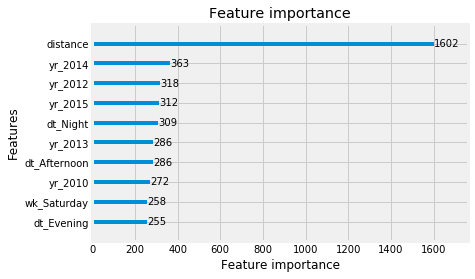

In [152]:
import lightgbm as lgbm

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

# pred_test_y = np.zeros(testx.shape[0])
# print(pred_test_y.shape)
train_set = lgbm.Dataset(trainx, trainy, silent=True)
# print(train_set)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
# print(model)
# pred_test_y = model.predict(testx, num_iteration = model.best_iteration)
# print(pred_test_y)

evaluate(model, list(df.columns), trainx, testx, trainy, testy)

ax = lgbm.plot_importance(model, max_num_features=10)
plt.show()

### Multicollinearity

In [47]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [163]:
# final_df.to_csv('multicollinearity_latlondiff_df.csv')
# final_vif.to_csv('multicollinearity_df_latlondiff_vif.csv')
# df1.to_csv('lat_lon_diff_df.csv')
# df2.to_csv('distance_df.csv')

In [10]:
# df11=pd.read_csv('lat_lon_diff_df.csv')
# df11.head()

#### Parameter tuning for light gbm model using GridSearchCV

In [9]:
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

estimator = lgbm.LGBMRegressor()#num_leaves=31)

param_grid = {
    'learning_rate': [0.05, 0.01], #0.001, 0.005, 
    'num_leaves': [15,25],
    'max_depth': [5, 6]#, #, 8, 10
    #'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(trainx, trainy)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 25}


In [43]:
%%time

import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

trainx=pd.read_csv('multicollinearity_latlondiff_df.csv')
estimator = lgbm.LGBMRegressor()

param_grid = {
    'learning_rate': [0.001, 0.005, 0.05], # 
    'num_leaves': [15, 20, 25, 31],
    'max_depth': [5, 6, 7, 8]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(trainx, trainy)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 31}
Wall time: 15min 16s


In [44]:
%%time

trainx=pd.read_csv('multicollinearity_latlondiff_df.csv')
estimator = lgbm.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.05, 0.01, 0.1], # 
    'max_depth': [8, 9, 10]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(trainx, trainy)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 10}
Wall time: 3min 12s


## Multicollinearity Analysis with lat_lon_diff

In [64]:
mcdf = pd.read_csv('lat_lon_diff_df.csv')
ylabels=mcdf['fare_amount']
mcdf = mcdf.iloc[:,2:]
print(ylabels.head())
mcdf.head()

0    4.500
1   16.900
2    5.700
3    7.700
4    5.300
Name: fare_amount, dtype: float64


,lat_diff,lon_diff,wk_Friday,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Afternoon,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,0.009,0.003,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.071,0.037,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.011,0.009,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.025,0.004,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.016,0.011,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [66]:
%%time

def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)

mcdf_nd = mcdf._get_numeric_data()
mc_df, mc_vif = iterate_vif(mcdf_nd)

Iteration # 1
Removing wk_Friday with VIF of inf
Iteration # 2
Removing dt_Afternoon with VIF of inf
Iteration # 3
Removing mn_April with VIF of inf
Iteration # 4
Removing dd_1 with VIF of inf
Iteration # 5
Removing yr_2009 with VIF of inf
Iteration # 6
Removing pc_1 with VIF of 40.600000
Iteration # 7
Complete
Wall time: 1h 53min 42s


In [70]:
mc_df.to_csv('multicollinearity_latlondiff_data.csv')
mc_vif.to_csv('multicollinearity_df_latlondiff_vif_data.csv')

In [71]:
# train_test_split
trainx, testx, trainy, testy = train_test_split(mc_df, ylabels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 62) (566601, 62) (1322068,) (566601,)


Training:   rmse = 3.61 	 mape = 18.72
Validation: rmse = 3.67 	 mape = 18.87


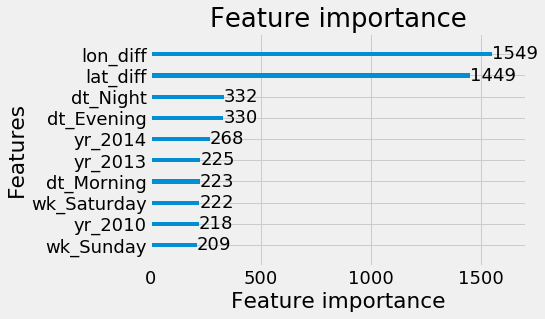

In [72]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': 10,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

train_set = lgbm.Dataset(trainx, trainy, silent=True)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)

evaluate(model, list(trainx.columns), trainx, testx, trainy, testy)

ax = lgbm.plot_importance(model, max_num_features=10)
plt.show()

In [73]:
import lightgbm as lgb

lgb_train = lgb.Dataset(trainx, trainy, free_raw_data=False)
lgb_val = lgb.Dataset(testx, testy, reference=lgb_train, free_raw_data=False)

core_params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 10,
    'nthread': 4,
    'verbose': 0,
    'metric': 'rmse'
}

training_set = lgb.Dataset(trainx, trainy, silent=True)
boost_rounds=300
early_stopping_rounds=500
validation_set=ylabels

evals_result = {}
gbm = lgb.train(core_params, # parameter dict to use
                train_set = lgb_train,
                num_boost_round=boost_rounds, # number of boosting rounds.
                early_stopping_rounds=early_stopping_rounds,
                valid_sets=lgb_val,
                evals_result=evals_result, # stores validation results.
                verbose_eval=False) # print evaluations during training.

evaluate(gbm, list(trainx.columns), trainx, testx, trainy, testy)


Training:   rmse = 3.59 	 mape = 18.52
Validation: rmse = 3.65 	 mape = 18.67


In [74]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(trainx, trainy)
evaluate(random_forest, list(trainx.columns), trainx, testx, trainy, testy)
trainx.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.8s finished


Training:   rmse = 2.63 	 mape = 16.26
Validation: rmse = 3.74 	 mape = 19.08


,lat_diff,lon_diff,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Evening,dt_Morning,...,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_2,pc_3,pc_4,pc_5
1818302,0.043,0.023,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1818588,0.077,0.060,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1345055,0.010,0.012,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
461281,0.012,0.007,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1793270,0.033,0.185,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0


[01:20:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 8.595403
Training:   rmse = 8.65 	 mape = 31.34
Validation: rmse = 8.6 	 mape = 31.35


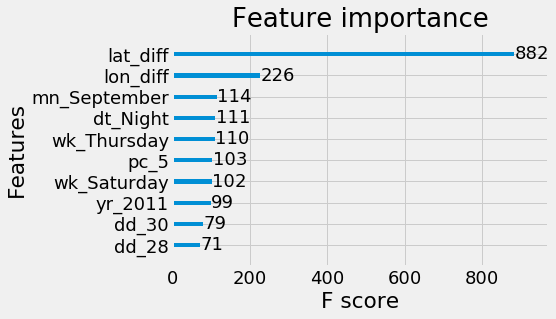

In [78]:
import xgboost as xgb3

data_dmatrix = xgb3.DMatrix(data=mcdf,label=ylabels)

xg_reg3 = xgb3.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

xg_reg3.fit(trainx,trainy)

preds = xg_reg3.predict(testx)

rmse = np.sqrt(mean_squared_error(testy, preds))
print("RMSE: %f" % (rmse))

evaluate(xg_reg3, list(trainx.columns), trainx, testx, trainy, testy)

xgb3.plot_importance(xg_reg3, max_num_features=10)
plt.show()

## Model without Multicolinearity

In [79]:
df_all = pd.read_csv('lat_lon_diff_df.csv')
y=df_all['fare_amount']
df = df_all.iloc[:,2:]
print(y.head())
df.head()

0    4.500
1   16.900
2    5.700
3    7.700
4    5.300
Name: fare_amount, dtype: float64


,lat_diff,lon_diff,wk_Friday,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Afternoon,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,0.009,0.003,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.071,0.037,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.011,0.009,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.025,0.004,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.016,0.011,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [81]:
# train_test_split
trainx, testx, trainy, testy = train_test_split(df, y, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 68) (566601, 68) (1322068,) (566601,)


Training:   rmse = 3.6 	 mape = 18.78
Validation: rmse = 3.67 	 mape = 18.93


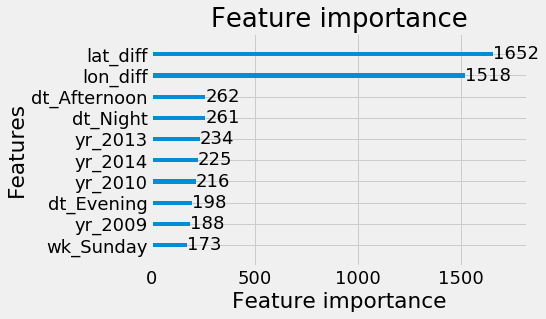

In [82]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': 10,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

train_set = lgbm.Dataset(trainx, trainy, silent=True)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)

evaluate(model, list(trainx.columns), trainx, testx, trainy, testy)

ax = lgbm.plot_importance(model, max_num_features=10)
plt.show()

Training:   rmse = 3.58 	 mape = 18.52
Validation: rmse = 3.65 	 mape = 18.66


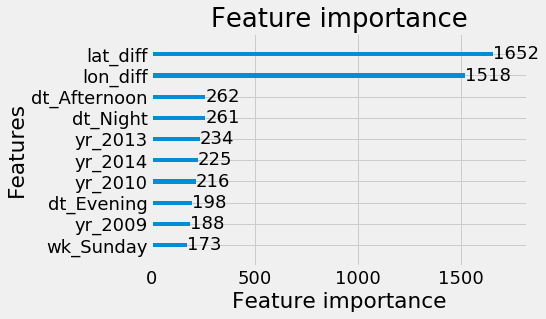

In [83]:
import lightgbm as lgb

lgb_train = lgb.Dataset(trainx, trainy, free_raw_data=False)
lgb_val = lgb.Dataset(testx, testy, reference=lgb_train, free_raw_data=False)

core_params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 10,
    'nthread': 4,
    'verbose': 0,
    'metric': 'rmse'
}

training_set = lgb.Dataset(trainx, trainy, silent=True)
boost_rounds=300
early_stopping_rounds=500
validation_set=ylabels

evals_result = {}
gbm = lgb.train(core_params, # parameter dict to use
                train_set = lgb_train,
                num_boost_round=boost_rounds, # number of boosting rounds.
                early_stopping_rounds=early_stopping_rounds,
                valid_sets=lgb_val,
                evals_result=evals_result, # stores validation results.
                verbose_eval=False) # print evaluations during training.

evaluate(gbm, list(trainx.columns), trainx, testx, trainy, testy)

ax = lgbm.plot_importance(model, max_num_features=10)
plt.show()

In [86]:
# Create the random forest
random_forest = RandomForestRegressor(max_depth = 10, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(trainx, trainy)
evaluate(random_forest, list(trainx.columns), trainx, testx, trainy, testy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   53.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


Training:   rmse = 3.69 	 mape = 19.81
Validation: rmse = 3.75 	 mape = 19.94
